# Figure 3

FALTA ESTO!!!!

In [2]:
import sys
sys.path.append("../src")

import warnings
warnings.filterwarnings("ignore")

import re
import PIL
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

from pathlib import Path

from Utils.utils import PPT
from Config.config import PATHS
from Utils.interaction import Performer
from Utils.utils import GetMeasurements
from Utils.indices import AlternationIndex
from Classes.cognitive_model_agents import AttendanceM2, FRAplus

### Load AICs

In [ ]:
file_all = PATHS['parameter_fit_results'] / Path('best_fit_all.json')
df_all = pd.read_json(file_all, lines=True)
df_all.sort_values(by=['AIC', 'model_name'], inplace=True)
df_parameters = df_all[['model_name', 'fixed_parameters', 'free_parameters']]
df_all.drop(columns=['free_parameters', 'fixed_parameters'], inplace=True)
df_all['deviance'] = df_all['deviance'].apply(lambda x: int(-x))
df_all['AIC'] = df_all['AIC'].apply(lambda x: int(x))
df_all['AIC_diff'] = df_all['AIC'] - df_all['AIC'].min()
df_all = df_all[['model_name', 'deviance', 'AIC', 'AIC_diff']].reset_index(drop=['index'])

df_all

,model_name,deviance,AIC,AIC_diff
0,FRA+Payoff+Attendance,18804,37620,0
1,Attendance-M2,18979,37965,345
2,Attendance-M3,19641,39288,1668
3,Attendance-M1,19915,39837,2217
4,MFP-M2,20613,41231,3611
5,MFP-M3,20704,41412,3792
6,AvailableSpace-M3,20765,41537,3917
7,AvailableSpace-M2,20800,41606,3986
8,FRA,21021,42049,4429
9,Fairness-M2,21043,42092,4472


### Distances between models

In [4]:
# ----- Inputs -----
# models = ['Random', 'WSLS-M1', 'WSLS-M2', 'WSLS-M3', 'Payoff-M1',
#           'Payoff-M2', 'Payoff-M3', 'Attendance-M1', 'Attendance-M2',
#           'Attendance-M3', 'AvailableSpace-M1', 'AvailableSpace-M2',
#           'AvailableSpace-M3', 'Fairness-M1', 'Fairness-M2', 'Fairness-M3',
#           'MFP-M1', 'MFP-M2', 'MFP-M3', 'FRA', 'FRA+Payoff+Attendance']

models = df_all['model_name'].values

mechanisms = ['Stochastic', 'Heuristic', 'Best-response', 'Error-correction', 'Schemata']
m2i = {
    'Stochastic': 0,
    'Heuristic': 1,
    'Best-response': 3,
    'Error-correction': 4,
    'Schemata': 5
}

# For each *base* model, list which high-level mechanisms it belongs to (by index).
dict_mechanisms = {
    'FRA+Payoff+Attendance': [4, 5],   # Error-correction + Schemata
    'FRA': [5],                        # Schemata
    'Attendance': [4],                 # Error-correction
    'Payoff': [4],                     # Error-correction
    'Fairness': [4],                   # Error-correction
    'AvailableSpace': [4],             # Error-correction
    'MFP': [3],                        # Best-response
    'WSLS': [1],                       # Heuristic
    'Random': [0]                      # Stochastic
}

In [5]:
# ----- Helpers -----
level_pattern = re.compile(r'-M(\d+)$')

def parse_base_and_level(model_name: str):
    """Return (base_name, level:int). If no level in the name, level=0."""
    m = level_pattern.search(model_name)
    if m:
        level = int(m.group(1))
        base = model_name[:m.start()]  # everything before '-M#'
    else:
        base = model_name
        level = 0
    return base, level

def base_for_model(model_name: str):
    """Return base_name"""
    m = level_pattern.search(model_name)
    if m:
        base = model_name[:m.start()]  # everything before '-M#'
    else:
        base = model_name
    return base

def mechanisms_for_model(model_name: str):
    """Return a set of mechanism indices for the given model name."""
    base, _ = parse_base_and_level(model_name)
    mech_list = dict_mechanisms.get(base, [])
    return set(mech_list)

def level_for_model(model_name: str):
    """Numeric level (ordinal). Models without -M# are treated as level 0."""
    base, lvl = parse_base_and_level(model_name)
    if base == 'Random':
        lvl = 1
    elif 'FRA' in base:
        lvl = 4
    return lvl

def model_distance(a: str, b: str):
    """Distance = 1/(#shared_mechanisms) + |level_a - level_b|; ∞ if none shared."""
    ma = mechanisms_for_model(a)
    mb = mechanisms_for_model(b)
    shared = len(ma & mb)
    if base_for_model(a) == base_for_model(b):
        m_distance = 0
    elif shared == 0:
        m_distance = 2
    else:
        m_distance = 1.0 / shared
    return m_distance

In [6]:
# ----- Mechanism-only distance (ignore levels here) -----
# distance = 1 / (#shared_mechanisms); ∞ if none shared
n = len(models)
D_mech = np.zeros((n, n), dtype=float)
for i in range(n):
    for j in range(n):
        if i == j:
            D_mech[i, j] = 0.0
            continue
        mi = mechanisms_for_model(models[i])
        mj = mechanisms_for_model(models[j])
        shared = len(mi & mj)
        if base_for_model(models[i]) == base_for_model(models[j]):
            m_distance = 0
        elif shared == 0:
            m_distance = 2
        else:
            m_distance = 1.0 / shared
        D_mech[i, j] = m_distance

dist_df = pd.DataFrame(D_mech, index=models, columns=models)

In [7]:
# ----- 1D embedding for mechanisms -----
mds1 = MDS(
    n_components=1,
    dissimilarity='precomputed',
    random_state=5,
    n_init=8,
    max_iter=1000,
    normalized_stress='auto'
)
mech_1d = mds1.fit_transform(D_mech).ravel()

# Optionally mean-center for nicer plotting
mech_1d = mech_1d - mech_1d.mean()

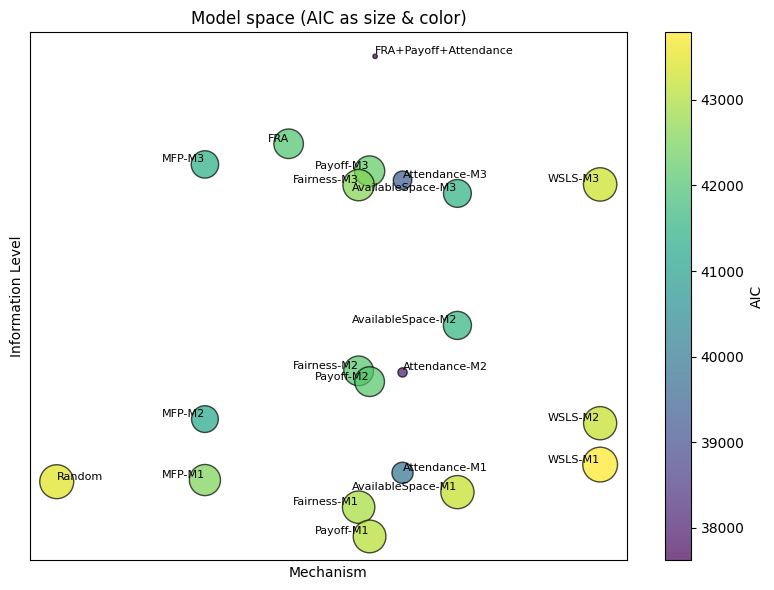

In [8]:
# ----- Build 2D embedding: (mechanism_axis, level_axis) -----
levels = np.array([level_for_model(m) for m in models], dtype=float)

emb_df = pd.DataFrame({
    'model': models,
    'mechanism_axis': mech_1d,  # learned 1D mechanism embedding
    'level': levels,             # explicit ordinal level axis
    'AIC': df_all['AIC'].values,
    'AIC_diff': df_all['AIC_diff'].values
})

# Fix strange mistake
emb_df.loc[12, 'mechanism_axis'] = emb_df.loc[4, 'mechanism_axis']
emb_df.loc[14, 'mechanism_axis'] = emb_df.loc[9, 'mechanism_axis']
emb_df.loc[11, 'mechanism_axis'] = emb_df.loc[10, 'mechanism_axis']
emb_df.loc[15, 'mechanism_axis'] = emb_df.loc[10, 'mechanism_axis']
emb_df.loc[8, 'mechanism_axis'] = emb_df.loc[0, 'mechanism_axis'] - 0.75
emb_df.loc[19, 'mechanism_axis'] = -3

# ----- Quick plot -----
# add vertical jitter
rng = np.random.default_rng(42)  # for reproducibility
jitter = rng.uniform(0, 1, size=len(emb_df))  # small noise around 0
emb_df['level_jittered'] = emb_df['level'] + jitter

# Normalize AIC for sizes
size_scale = 1 / emb_df['AIC_diff'].max()  # relative scaling
sizes = 10 + emb_df['AIC_diff'] * 0.1

# Scatter plot with color and size by AIC
plt.figure(figsize=(8, 6))
sc = plt.scatter(
    emb_df['mechanism_axis'], emb_df['level_jittered'],
    c=emb_df['AIC'], s=sizes, cmap='viridis', alpha=0.7, edgecolor='k'
)

# Labels for each point
for _, row in emb_df.iterrows():
    if ('Attendance' in row['model']) or ('Random' in row['model']):
        ha = 'left'
    else:
        ha = 'right'
    plt.text(row['mechanism_axis'], row['level_jittered'],
             row['model'], fontsize=8, ha=ha, va='bottom')

# Colorbar
cbar = plt.colorbar(sc)
cbar.set_label('AIC')

# Axes labels and title
plt.xlabel('Mechanism')
plt.xticks(ticks=[])
plt.ylabel('Information Level')
plt.yticks(ticks=[])
plt.title('Model space (AIC as size & color)')
plt.tight_layout()
plt.show()

### Simulate best fit model

In [9]:
df_parameters.index = df_parameters['model_name']

for model, row in df_parameters.iterrows():
    if model in ['Attendance-M2', 'FRA+Payoff+Attendance']:
        parameters = row['free_parameters']
        print('-'*60)
        print(model)
        print(parameters)

------------------------------------------------------------
FRA+Payoff+Attendance
{'inverse_temperature': 5.7047845439, 'bias': 0.8298543904, 'learning_rate': 0.18923347100000001, 'len_history': 3.7400626200000002, 'c': 0.5, 'delta': 0.1627092739}
------------------------------------------------------------
Attendance-M2
{'inverse_temperature': 5.3035335618, 'learning_rate': 0.18185628750000002, 'bias': 0.8156616184000001}


In [20]:
data_folder = PATHS['human_data']
file_name = 'all_data.csv'
file = data_folder / Path(file_name)
data_human = pd.read_csv(file)
data_human['model'] = 'human'

list_fixed_parameters = PPT.get_fixed_parameters(data_human)
dict_sizes = PPT.get_number_of_groups(data_human)

print(f"Number of fixed parameters combinations: {len(list_fixed_parameters)}")

num_simulations = sum(dict_sizes.values())
print(f"Total number of groups: {num_simulations}")

# BEST_MODEL = AttendanceM2
BEST_MODEL = FRAplus

Number of fixed parameters combinations: 27
Total number of groups: 101


In [ ]:
def get_free_parameters(model_name, fixed_parameters):
    mask1 = df_parameters['model_name'] == model_name 
    mask2 = df_parameters['fixed_parameters'].apply(
        lambda params: np.all([
            np.isclose(value, fixed_parameters[x]) for x, value in params.items()
        ])
    )
    mask = mask1 & mask2
    if not mask.any():
        raise ValueError(f"Model {model_name} with fixed parameters {fixed_parameters} not found.")
    df = df_parameters[mask]
    return df['free_parameters'].values[0]

def get_num_episodes(fixed_parameters):
    print(f'{fixed_parameters=}')
    num_players = fixed_parameters['num_agents']
    threshold = fixed_parameters['threshold']
    return dict_sizes[(num_players, threshold)]

data_folder = PATHS['simulated_data']

for i, fixed_parameters in enumerate(list_fixed_parameters):
    free_parameters = get_free_parameters(BEST_MODEL.name(), fixed_parameters)
    num_agents = fixed_parameters['num_agents']
    threshold = fixed_parameters['threshold']
    num_episodes = dict_sizes[(num_agents, threshold)]
    simulation_parameters = {
        'num_episodes':num_episodes,
        'num_rounds':30,
        'verbose':False
    }
    random.seed(1)
    seeds = [random.randint(0, 1000) for _ in range(num_episodes)]
    Performer.simple_run(
        agent_class=BEST_MODEL,
        fixed_parameters=fixed_parameters,
        free_parameters=free_parameters,
        simulation_parameters=simulation_parameters,
        measures=[],
        data_folder=data_folder,
        new_file=True,
        seeds=seeds
    )

In [ ]:
#Load data from FRAplus
simulation_numbers = list(range(1, num_simulations + 1))
df_list = []
for n in simulation_numbers:
    file_name = PATHS['simulated_data'] / Path(f'{FRAplus.name()}_{n}.csv')
    if file_name.exists():
        df = pd.read_csv(file_name)
        df['model'] = FRAplus.name()
        df_list.append(df)

data_sim1 = pd.concat(df_list, ignore_index=True)

#Load data from Attendance-M2
df_list = []
for n in simulation_numbers:
    file_name = PATHS['simulated_data'] / Path(f'{AttendanceM2.name()}_{n}.csv')
    if file_name.exists():
        df = pd.read_csv(file_name)
        df['model'] = AttendanceM2.name()
        df_list.append(df)

data_sim2 = pd.concat(df_list, ignore_index=True)

# Calculate alternation index per group for FRAplus
raw_df1 = PPT.concat_dfs(data_human, data_sim1)
raw_df1['session_round'] = raw_df1['round'].apply(lambda x: x % 30)
gm = GetMeasurements(
    data=raw_df1,
    measures=['efficiency', 'bounded_efficiency', 'inequality'],
    T=np.inf
)
df1 = gm.get_measurements()
alt_index = AlternationIndex.from_file(priority='sklearn')
df1['alternation_index'] = alt_index(df1)
df_jitter1 = df1.copy()
df_jitter1['efficiency'] = df_jitter1['efficiency'] + np.random.normal(0, 0.01, len(df_jitter1['efficiency']))
df_jitter1['inequality'] = df_jitter1['inequality'] + np.random.normal(0, 0.01, len(df_jitter1['inequality']))

# Calculate alternation index per group for Attendance
raw_df2 = PPT.concat_dfs(data_human, data_sim2)
raw_df2['session_round'] = raw_df2['round'].apply(lambda x: x % 30)
gm = GetMeasurements(
    data=raw_df2,
    measures=['efficiency', 'bounded_efficiency', 'inequality'],
    T=np.inf
)
df2 = gm.get_measurements()
alt_index = AlternationIndex.from_file(priority='sklearn')
df2['alternation_index'] = alt_index(df2)
df_jitter2 = df2.copy()
df_jitter2['efficiency'] = df_jitter2['efficiency'] + np.random.normal(0, 0.01, len(df_jitter2['efficiency']))
df_jitter2['inequality'] = df_jitter2['inequality'] + np.random.normal(0, 0.01, len(df_jitter2['inequality']))

### Display simulated best-fit model against human data

In [ ]:
# Load human data
human_data_folder = PATHS['human_data']
file_name = 'all_data.csv'
file = human_data_folder / Path(file_name)
data_human = pd.read_csv(file)
data_human['model'] = 'human'
data_human['round'] = data_human['round'].apply(lambda x: x % 30)

# Calculate measures for human data
gm = GetMeasurements(
    data=data_human,
    measures=['efficiency', 'bounded_efficiency', 'inequality', 'bounded_inequality'],
    T=np.inf
)
measures_human = gm.get_measurements()
alt_index = AlternationIndex.from_file(priority='sklearn')
measures_human['alternation_index'] = alt_index(measures_human)

# Load simulated data
sim_data_folder = PATHS['simulated_data']
file_name = 'FRAplus_measured.csv'
file = sim_data_folder / Path(file_name)
measures_best_fit = pd.read_csv(file)
measures_best_fit['model'] = BEST_MODEL.name()

# Concatenate human and simulated data
df1 = pd.concat([measures_human, measures_best_fit], ignore_index=True)
df_jitter1 = df1.copy()
df_jitter1['bounded_efficiency'] = df_jitter1['bounded_efficiency'] + np.random.normal(0, 0.01, len(df_jitter1['bounded_efficiency']))
df_jitter1['bounded_inequality'] = df_jitter1['bounded_inequality'] + np.random.normal(0, 0.01, len(df_jitter1['bounded_inequality']))



In [ ]:
fig, axes = plt.subplots(
    1, 2,
    figsize=(6, 4),
    tight_layout=True,
    sharex=False, sharey=False    
)

sns.kdeplot(
    x='inequality', y='bounded_efficiency',
    hue='model',style='model',
    data=df_jitter1, palette='colorblind', fill=True,
    ax=axes[0]
)
sns.scatterplot(
    x='inequality', y='bounded_efficiency',
    hue='model',style='model',
    data=df_jitter1, palette='colorblind',
    ax=axes[0, 0]
)
axes[0, 0].set_xlabel('Inequality')
axes[0, 0].set_ylabel('Bounded Efficiency')
axes[0, 0].set_title('FRAplus (1st)\nEfficiency vs. Inequality')
handles, labels = axes[0, 0].get_legend_handles_labels()
axes[0, 0].legend(
    title='Source',
    handles=handles,
    labels=['FRAplus', 'Humans'],
    loc='lower center',      # you can also use 'upper center'
    bbox_to_anchor=(0.5, -0.65),  # y < 0 moves it below the axes
    ncol=2,        # or choose a smaller number for multi‑row
)
axes[0, 0].grid()

### Panel A --- Individual incentives vs. Group benefit

In [ ]:
player_av_scores = data.groupby(['player']).agg({
    'score':'mean',
    'decision':'mean'
})

group_av_scores = data.groupby(['group']).agg({
    'score':'mean',
    'decision':'mean'
})

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(4,6), tight_layout=True)

# Individual incentives
sns.regplot(
    x='decision', y='score',
    scatter_kws={'alpha': 0.5}, 
    data=player_av_scores, ax=ax[0]
)
ax[0].set_xlabel("Av. player go")
ax[0].set_ylabel("Av. player score")
ax[0].set_title("Individual incentives")
ax[0].grid()
ax[0].set_ylim([-1,1])

# Harm to collective outcome

sns.regplot(
    x='decision', y='score', 
    scatter_kws={'alpha': 0.5}, 
    data=group_av_scores, ax=ax[1]
)
ax[1].set_xlabel("Av. session go")
ax[1].set_ylabel("Av. session score")
ax[1].set_title("Harm to collective outcome")
ax[1].grid()
ax[1].set_ylim([-1,1])

# Convert figure to image array
fig.suptitle("A", fontweight="bold")
fig.canvas.draw()
rgba_bytes = fig.canvas.buffer_rgba().tobytes()
width, height = fig.canvas.get_width_height()
pil_image = PIL.Image.frombytes(mode="RGBA", size=[width, height], data=rgba_bytes)
panel_A = np.array(pil_image)

Pearson coefficients per player

In [ ]:
r, p_value = pearsonr(player_av_scores['decision'], player_av_scores['score'])

print(f"Pearson correlation coefficient: {r:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"{r:.3f} (p={p_value:.3f})")

Pearson coefficients per group

In [ ]:
r, p_value = pearsonr(group_av_scores['decision'], group_av_scores['score'])

print(f"Pearson correlation coefficient: {r:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"{r:.3f} (p={p_value:.3f})")

### Panel B --- Score per round vs per session

In [ ]:
fig, ax = plt.subplots(
    2,1, 
    figsize=(4,6), 
    tight_layout=True,
    sharey=False
)

# Learning: average score increases per round
sns.lineplot(
    x='round', y='score', data=data,
    ci=95, ax=ax[0]
)
ax[0].set_xlabel('Round')
ax[0].set_ylabel("Av. player score")
ax[0].set_title("Learning within session")
ax[0].grid()
ax[0].set_ylim([-1,1])

# Learning: average score increases per session
sns.boxplot(
    x='session', y='score', 
    data=data, ax=ax[1],
)
ax[1].set_xlabel('Session')
ax[1].set_ylabel("Av. player score")
ax[1].set_title("Learning between sessions")
ax[1].grid()
# ax[1].set_ylim([-1,1])

# Convert figure to image array
fig.suptitle("B", fontweight="bold")
fig.canvas.draw()
rgba_bytes = fig.canvas.buffer_rgba().tobytes()
width, height = fig.canvas.get_width_height()
pil_image = PIL.Image.frombytes(mode="RGBA", size=[width, height], data=rgba_bytes)
panel_B = np.array(pil_image)

Pearson round vs score

In [ ]:
pearson_coef, p_value = stats.pearsonr(data['score'], data['round'])

print(f"Pearson correlation coefficient: {pearson_coef}")
print(f"P-value: {p_value}")
print(f"{pearson_coef:.3f} (p={p_value:.3f})")

Difference in means between session

In [ ]:
# Get the unique session labels
sessions = data['session'].unique()

# Extract the scores for each session
scores_by_session = [data[data['session'] == session]['score'] for session in sessions]

# Perform the Kruskal-Wallis H-test
h_stat, p_value = stats.kruskal(*scores_by_session)

print(f"Kruskal-Wallis H statistic: {h_stat}")
print(f"P-value: {p_value}")
print(f"H={h_stat:.3f} (p={p_value:.3f})")

### Panels A and B 

In [ ]:
# fig = plt.figure(figsize=(12, 6), tight_layout=True)  # total width = 4 + 8 = 12, height = 6
# gs = gridspec.GridSpec(1, 12, figure=fig)  # 12 columns, 1 row

# ax1 = fig.add_subplot(gs[0, 0:4])
# ax1.imshow(panel_A)  

# ax2 = fig.add_subplot(gs[0, 4:12])
# ax2.imshow(panel_B)

# ax1.axis('off')
# ax2.axis('off')

fig, ax = plt.subplots(1, 2, figsize=(8,6), tight_layout=True)

ax[0].imshow(panel_A)  
ax[1].imshow(panel_B)

ax[0].axis('off')
ax[1].axis('off')

# Convert figure to image array
fig.canvas.draw()
rgba_bytes = fig.canvas.buffer_rgba().tobytes()
width, height = fig.canvas.get_width_height()
pil_image = PIL.Image.frombytes(mode="RGBA", size=[width, height], data=rgba_bytes)
panels_A_B = np.array(pil_image)

### Panel C --- Bounded efficiency vs. Bounded inequality

In [ ]:
df_jitter = df.copy()
n = df_jitter.shape[0]
sigma = 0.0075
df_jitter['bounded_inequality'] = df_jitter['bounded_inequality'] + np.random.normal(0, sigma, n)
df_jitter['bounded_efficiency'] = df_jitter['bounded_efficiency'] + np.random.normal(0, sigma, n)

fig = plt.figure(figsize=(8,6), constrained_layout=True)

# One “slot” in a larger layout could be outer[0]; here we just show the joint block
gs_outer = fig.add_gridspec(1, 1)
gs = gs_outer[0].subgridspec(
    2, 2, height_ratios=[1, 4], width_ratios=[4, 1],
    hspace=0.05, wspace=0.05
)

ax_joint  = fig.add_subplot(gs[1, 0])
ax_marg_x = fig.add_subplot(gs[0, 0], sharex=ax_joint)
ax_marg_y = fig.add_subplot(gs[1, 1], sharey=ax_joint)

# Joint (scatter)
sns.scatterplot(
    x='bounded_inequality', y='bounded_efficiency',
    # style='predicted_class', hue='predicted_class',
    data=df_jitter,
    # hue='treatment', style='num_players',
    alpha=0.4, ax=ax_joint,
    palette='icefire',
    s=20
)
ax_joint.grid()

# Marginals (histograms)
sns.histplot(data=df_jitter, x='bounded_inequality', ax=ax_marg_x, bins=30)
sns.histplot(data=df_jitter, y='bounded_efficiency', ax=ax_marg_y, bins=30)

# Tidy up the marginal axes
ax_marg_x.tick_params(axis="x", labelbottom=False)
ax_marg_x.set_xlabel('')

ax_marg_y.tick_params(axis="y", labelleft=False)
ax_marg_y.set_ylabel('')

sns.despine(ax=ax_marg_x, bottom=True)
sns.despine(ax=ax_marg_y, left=True)

# Labels (now this is a normal Matplotlib figure you control)
ax_joint.set_xlabel("Bounded Inequality")
ax_joint.set_ylabel("Bounded Efficiency")

# Show the alternating groups on the top-left corner
circle = patches.Ellipse(
    (0, 1), width=0.15, height=0.15,
    # transform=ax_joint.transAxes, 
    color='green', alpha=0.2, 
)
ax_joint.add_patch(circle)
# Add an arrow pointing to the cluster
ax_joint.annotate(
    'Alternating\n sessions',
    xy=(0.05, 0.935), xycoords='axes fraction',
    xytext=(0.6, 0.3), textcoords='axes fraction',
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=10
)

# Show the mixed groups on the top center
circle = patches.Ellipse(
    (0.25, 0.96), width=0.35, height=0.175,
    # transform=ax.transAxes, 
    color='orange', alpha=0.3, 
)
ax_joint.add_patch(circle)
# Add an arrow pointing to the cluster
ax_joint.annotate(
    'Mixed\n sessions',
    xy=(0.2, 0.925), xycoords='axes fraction',
    xytext=(0.6, 0.6), textcoords='axes fraction',
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=10
)

# Show the segmented groups on the top-right corner
circle = patches.Ellipse(
    (1.35, 1), width=1.5, height=0.15, 
    # transform=ax.transAxes, 
    color='blue', alpha=0.2
)
ax_joint.add_patch(circle)
# Add an arrow pointing to the cluster
ax_joint.annotate(
    'Segmented\n   sessions',
    xy=(0.8, 0.92), xycoords='axes fraction',
    xytext=(0.8, 0.7), textcoords='axes fraction',
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=10
)

# Convert figure to image array
fig.suptitle("C", fontweight="bold")
fig.canvas.draw()
rgba_bytes = fig.canvas.buffer_rgba().tobytes()
width, height = fig.canvas.get_width_height()
pil_image = PIL.Image.frombytes(mode="RGBA", size=[width, height], data=rgba_bytes)
panel_C = np.array(pil_image)

In [ ]:
print(df['bounded_efficiency'].describe())

In [ ]:
df[df['bounded_efficiency'] > 0].size / df.size

In [ ]:
print(df['bounded_inequality'].describe())

### Panels A, B and C

In [ ]:
# fig = plt.figure(figsize=(8, 12), tight_layout=True)  # total width = 4 + 8 = 12, height = 6
# gs = gridspec.GridSpec(1, 12, figure=fig)  # 12 columns, 1 row

# ax1 = fig.add_subplot(gs[0, 0:4])
# ax1.imshow(panels_A_B)  

# ax2 = fig.add_subplot(gs[0, 4:12])
# ax2.imshow(panel_C)

# ax1.axis('off')
# ax2.axis('off')

fig, ax = plt.subplots(2, 1, figsize=(8,12), tight_layout=True)

ax[0].imshow(panels_A_B)  
ax[1].imshow(panel_C)

ax[0].axis('off')
ax[1].axis('off')

# Convert figure to image array
fig.canvas.draw()
rgba_bytes = fig.canvas.buffer_rgba().tobytes()
width, height = fig.canvas.get_width_height()
pil_image = PIL.Image.frombytes(mode="RGBA", size=[width, height], data=rgba_bytes)
panels_A_B_C = np.array(pil_image)

### Panel D --- Influence of threshold and number of players

In [ ]:
fig, ax = plt.subplots(
    2, 1, 
    figsize=(4,6), 
    tight_layout=True,
    # sharex=True, sharey=True
)

# Efficiency per threshold and treatment
sns.lineplot(
    x='threshold', y='bounded_efficiency',
    data=df, ax=ax[0],
    err_style="bars",
    errorbar="ci",
    palette='icefire'
)
ax[0].set_xlabel("Bar's threshold")
ax[0].set_ylabel("Av. bounded efficiency")
ax[0].set_title("B. Efficiency per Threshold")
ax[0].grid()
ax[0].set_ylim([-1.6,1.1])

# Efficiency per number of agents and treatment
sns.lineplot(
    x='num_players', y='bounded_efficiency',
    data=df, ax=ax[1],
    err_style="bars",
    errorbar="ci",
    palette='icefire'
)
ax[1].set_xlabel("Number of players")
ax[1].set_ylabel("Av. bounded efficiency")
ax[1].set_title("B. Efficiency per Num. Players")
ax[1].grid()
ax[1].set_ylim([-1.6,1.1])


# Convert figure to image array
fig.suptitle("D", fontweight="bold")
fig.canvas.draw()
rgba_bytes = fig.canvas.buffer_rgba().tobytes()
width, height = fig.canvas.get_width_height()
pil_image = PIL.Image.frombytes(mode="RGBA", size=[width, height], data=rgba_bytes)
panel_D = np.array(pil_image)

### Panel E --- Effects of treatments

In [ ]:
data_2P = data[data['num_players'] == 2]
data_2P['treatment'] = data_2P['treatment'].apply(
    lambda x: 'partial information' if x == 'only score'
                else 'full information'
)
TwoP_group_av_scores = group_av_scores = data_2P.groupby(['treatment', 'group']).agg({
    'score':'mean',
    'decision':'mean'
})


def get_threshold_level(x:float) -> str:
    q = math.floor(x * 4 + 0.5) / 4.0   # redondeo a múltiplos de 0.25, half-up
    level = max(0.25, q)
    if level < 0.5:
        return 'low'
    elif level == 0.5:
        return 'middle'
    else:
        return 'high'

data_MP = data[data['num_players'] > 2]
data_MP['thresh_level'] = data_MP['threshold'].apply(get_threshold_level)
MP_group_av_scores = group_av_scores = data_MP.groupby(['treatment', 'group', 'threshold', 'thresh_level']).agg({
    'score':'mean',
    'decision':'mean'
}).reset_index()
MP_group_av_scores['bounded_efficiency'] = MP_group_av_scores['score'] / MP_group_av_scores['threshold']

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(4,6), tight_layout=True)

# Distribution of efficiency vs treatment in Two-player experiment
sns.boxplot(
    x='treatment', y='score',
    data=TwoP_group_av_scores, ax=ax[0], 
    order=['partial information', 'full information'],
    hue_order=['partial information', 'full information'],
)
# sns.swarmplot(
#     x='treatment', y='score', color='black',
#     data=TwoP_group_av_scores, ax=ax[0], order=['only score', 'score + grid'],
#     hue_order=['only score', 'score + grid'],
# )
ax[0].set_xlabel('Treatment')
ax[0].set_ylabel('Efficiency')
ax[0].set_title('Partial vs. Full information')
ax[0].legend().remove()
ax[0].grid()

# Distribution of efficiency vs treatment in Multi-player experiment
sns.boxplot(
    x='thresh_level', y='bounded_efficiency', hue='treatment',
    data=MP_group_av_scores, ax=ax[1], 
    order=['low', 'middle', 'high'],
    hue_order=['downwards', 'upwards'],
)
# sns.swarmplot(
#     x='thresh_level', y='score', hue='treatment', color='black',   
#     data=MP_group_av_scores, ax=ax[1],
# )
ax[1].set_xlabel('Threshold level')
ax[1].set_ylabel('Bounded Efficiency')
ax[1].set_title('Downwards vs. Upwards')
ax[1].legend(
    title='Treatment',
    loc='lower center', 
    bbox_to_anchor=(0.5, -0.6),
    ncol=2
)
ax[1].grid()

# Convert figure to image array
fig.suptitle("E", fontweight="bold")
fig.canvas.draw()
rgba_bytes = fig.canvas.buffer_rgba().tobytes()
width, height = fig.canvas.get_width_height()
pil_image = PIL.Image.frombytes(mode="RGBA", size=[width, height], data=rgba_bytes)
panel_E = np.array(pil_image)

### Panels D and E

In [ ]:
# fig, ax = plt.subplots(1, 3, figsize=(12,6), tight_layout=True)

# ax[0].imshow(panel_C)  
# ax[1].imshow(panel_D)
# ax[2].imshow(panel_E)

# ax[0].axis('off')
# ax[1].axis('off')
# ax[2].axis('off')

fig, ax = plt.subplots(1, 2, figsize=(8,6), tight_layout=True)

ax[0].imshow(panel_D)  
ax[1].imshow(panel_E)

ax[0].axis('off')
ax[1].axis('off')

# Convert figure to image array
fig.canvas.draw()
rgba_bytes = fig.canvas.buffer_rgba().tobytes()
width, height = fig.canvas.get_width_height()
pil_image = PIL.Image.frombytes(mode="RGBA", size=[width, height], data=rgba_bytes)
panels_D_E = np.array(pil_image)

Panels A to E

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(8,18), tight_layout=True)

ax[0].imshow(panels_A_B)  
ax[1].imshow(panel_C)  
ax[2].imshow(panels_D_E)

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

# Convert figure to image array
fig.canvas.draw()
rgba_bytes = fig.canvas.buffer_rgba().tobytes()
width, height = fig.canvas.get_width_height()
pil_image = PIL.Image.frombytes(mode="RGBA", size=[width, height], data=rgba_bytes)
panels_A_B_C_D_E = np.array(pil_image)

### Panel F --- Examples of playouts

In [ ]:
# Load human data
file_name = 'all_data.csv'
file = PATHS['human_data'] / Path(file_name)
print(f'Loading data from {file}...')
data = pd.read_csv(file)
data['source'] = 'humans'
data['model'] = data.apply(lambda row: f"{row['room']}-{row['num_players']}-{row['threshold']:.2f}", axis=1)
data['num_players'] = data['num_players'].astype(int)
data['round'] = data['round'].astype(int)
data['decision'] = data['decision'].astype(int)
data['group'] = data['group'].apply(lambda x: x.split('-')[0] if 'Grupo' not in x else x.split('-')[1])

# data = data[data['threshold'] != 1]
data.drop(columns=['room', 'date', 'timeup', 'time', 'attendance', 'ac_score', 'choice'], inplace=True)

In [ ]:
# Change round to round within session
dict_num_sessions = {}
for key, grp in data.groupby('group'):
    num_players = grp['num_players'].unique()[0]
    num_sessions = grp['threshold'].unique().size
    x = dict_num_sessions.get(num_players, None)
    if x != None and num_sessions != x:
        raise Exception('Inconsistent number of sessions per number of players')
    dict_num_sessions[num_players] = num_sessions
    
group_counter = {grp:0 for grp in data['group'].unique()}
rounds_counter = dict() 
dict_sessions_downwards = defaultdict()
dict_sessions_upwards = defaultdict()
data.sort_values(by=['group', 'treatment', 'threshold'], inplace=True)
for (group, treatment, threshold, num_players), grp in data.groupby(['group', 'treatment', 'threshold', 'num_players']):
    rounds_counter[(group, threshold)] = [grp['round'].min(), grp['round'].max()]
    num_thresholds = dict_num_sessions[num_players]
    if treatment == 'downwards':
        count = num_thresholds - group_counter[group]
        group_counter[group] += 1
        dict_sessions_downwards[(group, threshold)] = count
    elif treatment == 'upwards':
        group_counter[group] += 1
        count = group_counter[group]
        dict_sessions_upwards[(group, threshold)] = count
    else:
        dict_sessions_downwards[(group, threshold)] = 1

dict_sessions = dict_sessions_downwards.copy()
dict_sessions.update(dict_sessions_upwards)

def get_round(row):
    x = int(row['round'])
    m, M = rounds_counter[(row['group'], row['threshold'])]
    return (x - m) % M

data['round'] = data.apply(lambda row: get_round(row), axis=1).astype(int)
data['session'] = data.apply(lambda row: dict_sessions[(row['group'], row['threshold'])], axis=1)
# data['group'] = data.apply(lambda row: f"{row['group']}-{row['session']}", axis=1)
# data = data[data['round'] <= 30]

data.sort_values(by=['num_players', 'threshold'], inplace=True)

print('Group sizes:', ', '.join([str(x) for x in data['num_players'].unique()]))
print('Number of groups:', len(data['group'].unique()))

In [ ]:
# Calculate alternation index per group
gm = GetMeasurements(
    data=data,
    measures=['efficiency', 'bounded_efficiency', 'entropy', 'conditional_entropy', 'inequality', 'bounded_inequality'],
    T=25
)
df = gm.get_measurements()

# Find coordination type
alt_index = AlternationIndex.from_file(priority='mlp')
df['predicted_class'] = alt_index.classify(df)

In [ ]:
df_best = df[df['bounded_efficiency'] > 0.5]
df_best = df_best[df_best['threshold'] < 1]

# df_best['model'] = df_best.apply(lambda row: f"{row['model']}-{row['num_players']}-{row['threshold']:.2f}", axis=1)
df_best.sort_values(by=['bounded_efficiency', 'num_players'], ascending=False, inplace=True)
print('Num. of best sessions:', len(df_best))
# df_best

In [ ]:
# groups = df_best['model'].unique()
keep_groups_idx = [
    4, 3, 7, 8, 20, 16, 21, 5, 18, 14, 19, 22
]
groups = np.array(df_best['model'].unique())[keep_groups_idx].tolist()
categories = [
    'alternation', 'alternation', 'segmentation',
    'alternation', 'mixed', 'segmentation',
    'alternation', 'mixed', 'segmentation',
    'mixed', 'mixed', 'mixed'
]

fig, axes = plt.subplots(
    12, 1, 
    figsize=(4, 18),
    tight_layout=True
)

for i, group in enumerate(groups):
    df_aux = df_best[df_best['model'] == group]
    df_aux_aux = data[data['model'] == group]
    threshold = df_aux['threshold'].unique()[0]
    BE = df_aux['bounded_efficiency'].unique()[0]
    N = df_aux_aux['num_players'].values[0]
    B = int(df_aux_aux['threshold'].values[0] * N)
    # classification = df_aux['predicted_class'].values[0]
    classification = categories[i]
    # classification = i
    bar_renderer = BarRenderer(data=df_aux_aux)
    bar_renderer.render(
        ax=axes[i],
        title=f"N={N}, B={B}, B.E.={BE:.2f}, Type={classification}",
        num_rounds=25
    )

# Convert figure to image array
fig.suptitle("F\n", fontweight="bold")
fig.canvas.draw()
rgba_bytes = fig.canvas.buffer_rgba().tobytes()
width, height = fig.canvas.get_width_height()
pil_image = PIL.Image.frombytes(mode="RGBA", size=[width, height], data=rgba_bytes)
panel_F = np.array(pil_image)

### All panels

In [ ]:
fig = plt.figure(figsize=(12, 18), tight_layout=True)  
gs = gridspec.GridSpec(1, 16, figure=fig)  

ax1 = fig.add_subplot(gs[0, 0:8])
ax1.imshow(panels_A_B_C_D_E)  

ax2 = fig.add_subplot(gs[0, 8:12])
ax2.imshow(panel_F)

ax1.axis('off')
ax2.axis('off')

In [ ]:
fig.savefig(PATHS['figures_for_paper'] / 'Short_Fig2.png', dpi=300, bbox_inches='tight')

---

### Regressions

In [ ]:
formula = 'score ~ treatment + num_players + threshold + round + session ' 
formula += '+ num_players * threshold + round * session + treatment * threshold + treatment * num_players'
lm = ols(formula, data).fit()

print(lm.summary())

In [ ]:
# Calculate alternation index per group
gm = GetMeasurements(
    data=data,
    measures=['efficiency', 'bounded_efficiency', 'entropy', 'conditional_entropy', 'inequality'],
)
df = gm.get_measurements()

alt_index = AlternationIndex.from_file(priority='sklearn')
df['alternation_index'] = alt_index(df)

df.head(2)

In [ ]:
formula = 'bounded_efficiency ~ num_players + threshold + num_players * threshold'
lm = ols(formula, df).fit()

print(lm.summary())

In [ ]:
formula = 'bounded_efficiency ~ treatment + num_players + threshold'
formula += '+ num_players * threshold + treatment * threshold + treatment * num_players'
lm = ols(formula, df[df['num_players'] > 2]).fit()

print(lm.summary())

In [ ]:
formula = 'alternation_index ~ treatment + num_players + threshold'
formula += '+ num_players * threshold + treatment * threshold + treatment * num_players'
lm = ols(formula, df).fit()

print(lm.summary())

### Check collective action dilemma

In [ ]:
player_av_scores = data.groupby(['player']).agg({
    'score':'mean',
    'decision':'mean'
})

group_av_scores = data.groupby(['group']).agg({
    'score':'mean',
    'decision':'mean'
})

In [ ]:
from scipy.stats import pearsonr

In [ ]:
r, p_value = pearsonr(player_av_scores['decision'], player_av_scores['score'])

print(f"Pearson correlation coefficient: {r:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"{r:.3f} (p={p_value:.3f})")

In [ ]:
r, p_value = pearsonr(group_av_scores['decision'], group_av_scores['score'])

print(f"Pearson correlation coefficient: {r:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"{r:.3f} (p={p_value:.3f})")

---